Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Tutorial #1: Train an image classification model with Azure Machine Learning

In this tutorial, you train a machine learning model both locally and on remote compute resources. You'll use the training and deployment workflow for Azure Machine Learning service (preview) in a Python Jupyter notebook.  You can then use the notebook as a template to train your own machine learning model with your own data. This tutorial is **part one of a two-part tutorial series**.  

This tutorial trains a simple logistic regression using the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset and [scikit-learn](http://scikit-learn.org) with Azure Machine Learning.  MNIST is a popular dataset consisting of 70,000 grayscale images. Each image is a handwritten digit of 28x28 pixels, representing a number from 0 to 9. The goal is to create a multi-class classifier to identify the digit a given image represents. 

Learn how to:

> * Set up your development environment
> * Access and examine the data
> * Train a simple logistic regression model locally using the popular scikit-learn machine learning library 
> * Train multiple models on a remote cluster
> * Review training results, find and register the best model

You'll learn how to select a model and deploy it in [part two of this tutorial](deploy-models.ipynb) later. 

## Prerequisites

Use [these instructions](https://aka.ms/aml-how-to-configure-environment) to:  
* Create a workspace and its configuration file (**config.json**)  
* Save your **config.json** to the same folder as this notebook

## Set up your development environment

All the setup for your development work can be accomplished in a Python notebook.  Setup includes:

* Importing Python packages
* Connecting to a workspace to enable communication between your local computer and remote resources
* Creating an experiment to track all your runs
* Creating a remote compute target to use for training

### Import packages

Import Python packages you need in this session. Also display the Azure Machine Learning SDK version.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import azureml
from azureml.core import Workspace, Run

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.2


### Connect to workspace

Create a workspace object from the existing workspace. `Workspace.from_config()` reads the file **config.json** and loads the details into an object named `ws`.

In [2]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, ws.location, sep = '\t')

Found the config file in: /home/nbuser/library/aml_config/config.json
AMLSworkspace	westeurope	resgrpAMLS	westeurope


### Create experiment

Create an experiment to track the runs in your workspace. A workspace can have muliple experiments. 

In [3]:
experiment_name = 'sklearn-mnist'

from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

### Create or Attach existing AmlCompute
You will need to create a [compute target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) for training your model. In this tutorial, you create `AmlCompute` as your training compute resource.

**Creation of AmlCompute takes approximately 5 minutes.** If the AmlCompute with that name is already in your workspace this code will skip the creation process.

In [4]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpucluster")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('found compute target. just use it. ' + compute_name)
else:
    print('creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                                min_nodes = compute_min_nodes, 
                                                                max_nodes = compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)
    
    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
     # For a more detailed view of current AmlCompute status, use the 'status' property    
    print(compute_target.status.serialize())

found compute target. just use it. cpucluster


You now have the necessary packages and compute resources to train a model in the cloud. 

## Explore data

Before you train a model, you need to understand the data that you are using to train it.  You also need to copy the data into the cloud so it can be accessed by your cloud training environment.  In this section you learn how to:

* Download the MNIST dataset
* Display some sample images
* Upload data to the cloud

### Download the MNIST dataset

Download the MNIST dataset and save the files into a `data` directory locally.  Images and labels for both training and testing are downloaded.

In [5]:
import os
import urllib.request

os.makedirs('./data', exist_ok = True)

urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename='./data/train-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename='./data/train-labels.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename='./data/test-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename='./data/test-labels.gz')

('./data/test-labels.gz', <http.client.HTTPMessage at 0x7f579eb996a0>)

### Display some sample images

Load the compressed files into `numpy` arrays. Then use `matplotlib` to plot 30 random images from the dataset with their labels above them. Note this step requires a `load_data` function that's included in an `util.py` file. This file is included in the sample folder. Please make sure it is placed in the same folder as this notebook. The `load_data` function simply parses the compresse files into numpy arrays.

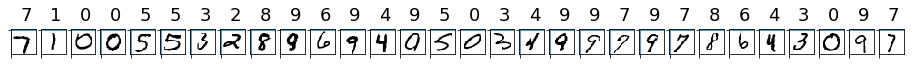

In [6]:
# make sure utils.py is in the same directory as this code
from utils import load_data

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the model converge faster.
X_train = load_data('./data/train-images.gz', False) / 255.0
y_train = load_data('./data/train-labels.gz', True).reshape(-1)

X_test = load_data('./data/test-images.gz', False) / 255.0
y_test = load_data('./data/test-labels.gz', True).reshape(-1)

# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

Now you have an idea of what these images look like and the expected prediction outcome.

### Upload data to the cloud

Now make the data accessible remotely by uploading that data from your local machine into Azure so it can be accessed for remote training. The datastore is a convenient construct associated with your workspace for you to upload/download data, and interact with it from your remote compute targets. It is backed by Azure blob storage account.

The MNIST files are uploaded into a directory named `mnist` at the root of the datastore.

In [7]:
ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)

ds.upload(src_dir='./data', target_path='mnist', overwrite=True, show_progress=True)

AzureBlob amlsworkspace9663571855 azureml-blobstore-4446f3c5-7943-4ab5-b1f3-5e4c7ede791c


$AZUREML_DATAREFERENCE_1ff1e9ef8a06425e9de5c2981ef3a4ec

You now have everything you need to start training a model. 

## Train a local model

Train a simple logistic regression model using scikit-learn locally.

**Training locally can take a minute or two** depending on your computer configuration.

In [8]:
%%time
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)

CPU times: user 1min 57s, sys: 2.6 s, total: 2min
Wall time: 2min


Next, make predictions using the test set and calculate the accuracy.

In [9]:
y_hat = clf.predict(X_test)
print(np.average(y_hat == y_test))

0.9201


With just a few lines of code, you have a 92% accuracy.

## Train on a remote cluster

Now you can expand on this simple model by building a model with a different regularization rate. This time you'll train the model on a remote resource.  

For this task, submit the job to the remote training cluster you set up earlier.  To submit a job you:
* Create a directory
* Create a training script
* Create an estimator object
* Submit the job 

### Create a directory

Create a directory to deliver the necessary code from your computer to the remote resource.

In [10]:
import os
script_folder = './sklearn-mnist'
os.makedirs(script_folder, exist_ok=True)

### Create a training script

To submit the job to the cluster, first create a training script. Run the following code to create the training script called `train.py` in the directory you just created. This training adds a regularization rate to the training algorithm, so produces a slightly different model than the local version.

In [11]:
%%writefile $script_folder/train.py

import argparse
import os
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

from azureml.core import Run
from utils import load_data

# let user feed in 2 parameters, the location of the data files (from datastore), and the regularization rate of the logistic regression model
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--regularization', type=float, dest='reg', default=0.01, help='regularization rate')
args = parser.parse_args()

data_folder = os.path.join(args.data_folder, 'mnist')
print('Data folder:', data_folder)

# load train and test set into numpy arrays
# note we scale the pixel intensity values to 0-1 (by dividing it with 255.0) so the model can converge faster.
X_train = load_data(os.path.join(data_folder, 'train-images.gz'), False) / 255.0
X_test = load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0
y_train = load_data(os.path.join(data_folder, 'train-labels.gz'), True).reshape(-1)
y_test = load_data(os.path.join(data_folder, 'test-labels.gz'), True).reshape(-1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep = '\n')

# get hold of the current run
run = Run.get_context()

print('Train a logistic regression model with regularizaion rate of', args.reg)
clf = LogisticRegression(C=1.0/args.reg, random_state=42)
clf.fit(X_train, y_train)

print('Predict the test set')
y_hat = clf.predict(X_test)

# calculate accuracy on the prediction
acc = np.average(y_hat == y_test)
print('Accuracy is', acc)

run.log('regularization rate', np.float(args.reg))
run.log('accuracy', np.float(acc))

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=clf, filename='outputs/sklearn_mnist_model.pkl')

Writing ./sklearn-mnist/train.py


Notice how the script gets data and saves models:

+ The training script reads an argument to find the directory containing the data.  When you submit the job later, you point to the datastore for this argument:
`parser.add_argument('--data-folder', type=str, dest='data_folder', help='data directory mounting point')`


+ The training script saves your model into a directory named outputs. <br/>
`joblib.dump(value=clf, filename='outputs/sklearn_mnist_model.pkl')`<br/>
Anything written in this directory is automatically uploaded into your workspace. You'll access your model from this directory later in the tutorial.

The file `utils.py` is referenced from the training script to load the dataset correctly.  Copy this script into the script folder so that it can be accessed along with the training script on the remote resource.

In [12]:
import shutil
shutil.copy('utils.py', script_folder)

'./sklearn-mnist/utils.py'

### Create an estimator

An estimator object is used to submit the run.  Create your estimator by running the following code to define:

* The name of the estimator object, `est`
* The directory that contains your scripts. All the files in this directory are uploaded into the cluster nodes for execution. 
* The compute target.  In this case you will use the AmlCompute you created
* The training script name, train.py
* Parameters required from the training script 
* Python packages needed for training

In this tutorial, this target is AmlCompute. All files in the script folder are uploaded into the cluster nodes for execution. The data_folder is set to use the datastore (`ds.as_mount()`).

In [13]:
from azureml.train.estimator import Estimator

script_params = {
    '--data-folder': ds.as_mount(),
    '--regularization': 0.8
}

est = Estimator(source_directory=script_folder,
                script_params=script_params,
                compute_target=compute_target,
                entry_script='train.py',
                conda_packages=['scikit-learn'])

### Submit the job to the cluster

Run the experiment by submitting the estimator object.

In [14]:
run = exp.submit(config=est)
run

Experiment,Id,Type,Status,Details Page,Docs Page
sklearn-mnist,sklearn-mnist_1544440467089,azureml.scriptrun,Queued,Link to Azure Portal,Link to Documentation


Since the call is asynchronous, it returns a **Preparing** or **Running** state as soon as the job is started.

## Monitor a remote run

In total, the first run takes **approximately 10 minutes**. But for subsequent runs, as long as the script dependencies don't change, the same image is reused and hence the container start up time is much faster.

Here is what's happening while you wait:

- **Image creation**: A Docker image is created matching the Python environment specified by the estimator. The image is uploaded to the workspace. Image creation and uploading takes **about 5 minutes**. 

  This stage happens once for each Python environment since the container is cached for subsequent runs.  During image creation, logs are streamed to the run history. You can monitor the image creation progress using these logs.

- **Scaling**: If the remote cluster requires more nodes to execute the run than currently available, additional nodes are added automatically. Scaling typically takes **about 5 minutes.**

- **Running**: In this stage, the necessary scripts and files are sent to the compute target, then data stores are mounted/copied, then the entry_script is run. While the job is running, stdout and the ./logs directory are streamed to the run history. You can monitor the run's progress using these logs.

- **Post-Processing**: The ./outputs directory of the run is copied over to the run history in your workspace so you can access these results.


You can check the progress of a running job in multiple ways. This tutorial uses a Jupyter widget as well as a `wait_for_completion` method. 

### Jupyter widget

Watch the progress of the run with a Jupyter widget.  Like the run submission, the widget is asynchronous and provides live updates every 10-15 seconds until the job completes.

In [17]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 's…

### Get log results upon completion

Model training and monitoring happen in the background. Wait until the model has completed training before running more code. Use `wait_for_completion` to show when the model training is complete.

In [18]:
run.wait_for_completion(show_output=False) # specify True for a verbose log

{'runId': 'sklearn-mnist_1544440467089',
 'target': 'cpucluster',
 'status': 'Completed',
 'startTimeUtc': '2018-12-10T11:20:14.932745Z',
 'endTimeUtc': '2018-12-10T11:26:17.00427Z',
 'properties': {'azureml.runsource': 'experiment',
  'ContentSnapshotId': '51574b68-e0f3-4fe3-81eb-fb840f282f27'},
 'runDefinition': {'Script': 'train.py',
  'Arguments': ['--data-folder',
   '$AZUREML_DATAREFERENCE_workspaceblobstore',
   '--regularization',
   '0.8'],
  'SourceDirectoryDataStore': None,
  'Framework': 0,
  'Communicator': 0,
  'Target': 'cpucluster',
  'DataReferences': {'workspaceblobstore': {'DataStoreName': 'workspaceblobstore',
    'Mode': 'Mount',
    'PathOnDataStore': None,
    'PathOnCompute': None,
    'Overwrite': False}},
  'JobName': None,
  'AutoPrepareEnvironment': True,
  'MaxRunDurationSeconds': None,
  'NodeCount': 1,
  'Environment': {'Python': {'InterpreterPath': 'python',
    'UserManagedDependencies': False,
    'CondaDependencies': {'name': 'project_environment',
  

### Display run results

You now have a model trained on a remote cluster.  Retrieve the accuracy of the model:

In [19]:
print(run.get_metrics())

{'regularization rate': 0.8, 'accuracy': 0.9204}


In the next tutorial you will explore this model in more detail.

## Register model

The last step in the training script wrote the file `outputs/sklearn_mnist_model.pkl` in a directory named `outputs` in the VM of the cluster where the job is executed. `outputs` is a special directory in that all content in this  directory is automatically uploaded to your workspace.  This content appears in the run record in the experiment under your workspace. Hence, the model file is now also available in your workspace.

You can see files associated with that run.

In [20]:
print(run.get_file_names())

['azureml-logs/60_control_log.txt', 'azureml-logs/80_driver_log.txt', 'outputs/sklearn_mnist_model.pkl', 'driver_log', 'azureml-logs/azureml.log', 'azureml-logs/55_batchai_execution.txt']


Register the model in the workspace so that you (or other collaborators) can later query, examine, and deploy this model.

In [21]:
# register model 
model = run.register_model(model_name='sklearn_mnist', model_path='outputs/sklearn_mnist_model.pkl')
print(model.name, model.id, model.version, sep = '\t')

Deprecated, use RunHistoryFacade.assets instead.


sklearn_mnist	sklearn_mnist:1	1


## Next steps

In this Azure Machine Learning tutorial, you used Python to:

> * Set up your development environment
> * Access and examine the data
> * Train a simple logistic regression locally using the popular scikit-learn machine learning library
> * Train multiple models on a remote cluster
> * Review training details and register the best model

You are ready to deploy this registered model using the instructions in the next part of the tutorial series:

> [Tutorial 2 - Deploy models](img-classification-part2-deploy.ipynb)